In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras import Sequential, Input, Model
from keras.activations import relu
from keras.layers import Dense,Dropout
from keras import utils
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.callbacks import EarlyStopping
import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing  import MinMaxScaler, StandardScaler, RobustScaler, normalize

In [73]:
def load_data(path_db: str) -> pd.DataFrame:
    df = pd.read_csv(path_db, delimiter=";", na_values="n/d")
    df["FECHA"] = pd.to_datetime(df["FECHA"], format="%d/%m/%y")
    df.set_index("FECHA", inplace=True)
    df.dropna(inplace=True)
    return df

In [74]:
def series_to_supervised(df: pd.DataFrame,
                         cols_names_inputs: list,
                         cols_names_outputs: list,
                         time_previous_input: int=0,
                         time_forecast_output: int=0) -> tuple[pd.DataFrame, pd.DataFrame]:

    # For inputs sequence (t-time_previous_input, ..., t-1).
    df_with_time_steps = pd.DataFrame()
    list_col_names_inputs = []
    for time_step in range(time_previous_input, 0, -1):
        for col_name in cols_names_inputs:
            new_col_name_input = '{}_t-{}'.format(col_name, time_step)
            df_with_time_steps[new_col_name_input] = df[col_name].shift(-time_step)
            list_col_names_inputs.append(new_col_name_input)

    # For outputs sequence (t, t+1, ..., t+time_forecast_output).
    list_col_names_outputs = []
    for time_step in range(time_forecast_output):
        for col_name in cols_names_outputs:
            new_col_name_output = '{}_t+{}'.format(col_name, time_step)
            df_with_time_steps[new_col_name_output] = df[col_name].shift(time_step)
            list_col_names_outputs.append(new_col_name_output)

    df_with_time_steps.dropna(inplace=True)
    return df_with_time_steps[list_col_names_inputs].copy(), df_with_time_steps[list_col_names_outputs].copy()

In [75]:
def build_mlp_model(numero_inputs: int,numero_outputs, numero_de_neuronas_capa_oculta: int,function_activation: str,uso_bias: bool, num_hidden_layers:int=2):
    
    input_layer = Input(shape=(numero_inputs,), name= "capa_entrada")
    x = Dense(units=numero_de_neuronas_capa_oculta,
                                    activation=function_activation,
                                    name="capa_oculta_1",
                                    use_bias=uso_bias)(input_layer)
    x = Dropout(rate=0.1)(x)

    for hidlayer in range (num_hidden_layers-1):

        x = Dense(units=numero_de_neuronas_capa_oculta,
                                        activation=function_activation,
                                        name="capa_oculta{}".format(hidlayer+1),
                                        use_bias=uso_bias)(x)
        x= Dropout(rate=0.1)(x)
    output_layer = Dense(units=numero_outputs, name="capa_salida")(x)

    model = Model(inputs=input_layer, outputs=output_layer)
   
    return model

In [76]:
def plot_results(history_object ,  title_plot: str):
    dict_resultado_historico = history_object.history

    x_values = history_object.epoch
    y_entrenamiento = dict_resultado_historico["loss"]
    y_validacion = dict_resultado_historico["val_loss"]

    plt.plot(x_values, y_entrenamiento, label="Entrenamiento", c="darkblue")
    plt.plot(x_values, y_validacion, label="validación" ,c="blue")

    plt.xlabel("Etapas")
    plt.ylabel("Error(loss)")
    plt.title()
    plt.legend
    plt.show

In [77]:
df_adra = load_data("adra.csv")

In [78]:
df_inputs, df_outputs = series_to_supervised(
    df_adra,
    ['Al10Rad'], 
    ["Al10ETo"],
    7,
    2)

###################################################
###########Univariate forecasting ones step########
###################################################
times_previous_input = 3
times_forecast_output = 1
col_names_inputs = ["Al10Rad"]
col_names_outputs = ["Al10ETo"]
df_inputs, df_outputs = series_to_supervised(
    df_adra,
    col_names_inputs,
    col_names_outputs,
    times_previous_input,
    times_forecast_output
)

# otra forma =df_train, df_val = train_test_split(pd.concat([df_inputs, df_outputs], axis=1), train_size=0.8, random_state=123) 
df_train_inputs, df_val_inputs, df_train_outputs, df_val_outputs = train_test_split(df_inputs, df_outputs, train_size=0.8, random_state=123) 


arr_train_inputs = df_train_inputs.to_numpy()
arr_train_outputs = df_train_outputs.to_numpy()
arr_val_inputs = df_val_inputs.to_numpy()
arr_val_outputs = df_val_outputs.to_numpy()


# decisiones en el proceso de modelado. Hiperparametros
numero_de_neuronas_capa_oculta= 60
function_activation="relu"
uso_bias = True
funcion_entrenamiento ="adam"
loss_funcion= "mse"
list_metrics = ["mae","mape"]
batch_size = 10000
numero_de_epocas = 50
numero_outputs = 1
numero_inputs = len(col_names_inputs) * times_previous_input



model = build_mlp_model(numero_inputs=numero_inputs,
                        numero_outputs=numero_outputs,
                        numero_de_neuronas_capa_oculta=numero_de_neuronas_capa_oculta,
                        function_activation=function_activation,
                        uso_bias=uso_bias,
)      

model.compile(optimizer=funcion_entrenamiento,
              loss=loss_funcion,
              metrics=list_metrics)




history_object =model.fit(
                    arr_train_inputs,
                    arr_train_outputs,
                    batch_size=batch_size,
                    validation_data=(arr_val_inputs, arr_val_outputs),
                    epochs=numero_de_epocas,
                    
)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 8.8900 - mae: 2.3177 - mape: 69.2854 - val_loss: 2.5731 - val_mae: 1.3327 - val_mape: 36.4584
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 5.9077 - mae: 1.8245 - mape: 55.5029 - val_loss: 0.9987 - val_mae: 0.7697 - val_mape: 23.1692
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 4.5753 - mae: 1.5959 - mape: 50.5012 - val_loss: 0.6663 - val_mae: 0.6201 - val_mape: 23.8056
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 4.2731 - mae: 1.5706 - mape: 51.7362 - val_loss: 1.0723 - val_mae: 0.8455 - val_mape: 33.0197
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.7413 - mae: 1.6845 - mape: 56.4647 - val_loss: 1.5337 - val_mae: 1.0494 - val_mape: 39.9645
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 5.1248 - mae: 1.7648 - mape: 59.6689 - val_loss: 1.6850 - val_mae: 1.1097 - val_mape: 41.9723
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 5.1404 - mae: 1.7641 - mape: 59.7291 -

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ capa_entrada (InputLayer)       │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta_1 (Dense)           │ (None, 60)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta1 (Dense)            │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_salida (Dense)             │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,961 (15.47 KB)

 Trainable params: 3,961 (15.47 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 6.1626 - mae: 1.9433 - mape: 65.7313 - val_loss: 0.8357 - val_mae: 0.7280 - val_mape: 28.0062
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 4.2728 - mae: 1.5762 - mape: 52.8207 - val_loss: 0.6806 - val_mae: 0.6138 - val_mape: 20.2974
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 3.9111 - mae: 1.4892 - mape: 48.1633 - val_loss: 1.2545 - val_mae: 0.8842 - val_mape: 25.0273
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.3802 - mae: 1.5584 - mape: 48.7542 - val_loss: 1.5582 - val_mae: 1.0094 - val_mape: 27.9456
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 4.5783 - mae: 1.5833 - mape: 49.0522 - val_loss: 1.4210 - val_mae: 0.9547 - val_mape: 26.5751
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.1191 - mae: 1.5220 - mape: 47.2649 - val_loss: 1.0870 - val_mae: 0.8120 - val_mape: 23.3671
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 4.0182 - mae: 1.4936 - mape: 46.8409 - 

<function matplotlib.pyplot.show(close=None, block=None)>

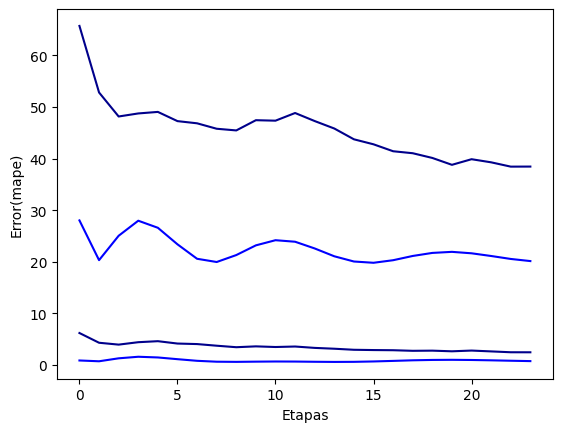

In [79]:
#Model
model = build_mlp_model(numero_inputs=numero_inputs,
                        numero_outputs=numero_outputs,
                        numero_de_neuronas_capa_oculta=numero_de_neuronas_capa_oculta,
                        function_activation=function_activation,
                        uso_bias=uso_bias,
)      
model.summary()

model.compile(optimizer=funcion_entrenamiento,
              loss=loss_funcion,
              metrics=list_metrics)


early_Stopping = EarlyStopping(monitor="val_loss", patience=10)
early_Stopping2 = EarlyStopping(monitor="val_mae", patience=30)

history_object =model.fit(
                    arr_train_inputs,
                    arr_train_outputs,
                    batch_size=batch_size,
                    validation_data=(arr_val_inputs, arr_val_outputs),
                    epochs=numero_de_epocas,
                    callbacks=[early_Stopping, early_Stopping2]

)

dict_resultado_historico = history_object.history

x_values = history_object.epoch
y_entrenamiento = dict_resultado_historico["loss"]
y_validacion = dict_resultado_historico["val_loss"]

plt.plot(x_values, y_entrenamiento, label="Entrenamiento", c="darkblue")
plt.plot(x_values, y_validacion, label="validación" ,c="blue")

plt.xlabel("Etapas")
plt.ylabel("Error(loss)")
plt.legend
plt.show


y_entrenamiento_mape = dict_resultado_historico["mape"]
y_validacion_mape = dict_resultado_historico["val_mape"]
plt.plot(x_values, y_entrenamiento_mape, label="Entrenamiento", c="darkblue")
plt.plot(x_values, y_validacion_mape, label="validación" ,c="blue")

plt.xlabel("Etapas")
plt.ylabel("Error(mape)")
plt.legend
plt.show